In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm
from scipy.spatial import cKDTree
import scipy.stats as stats
import numpy as np
import yaml
import os


# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

In [2]:
# Generate 20 intervals between 0 and 50,000
interval_edges = np.linspace(0, 100000, num=21)

# Create the distance ranges as tuples
distance_ranges = [(interval_edges[i], interval_edges[i+1]) for i in range(len(interval_edges)-1)]

print(distance_ranges)

[(0.0, 5000.0), (5000.0, 10000.0), (10000.0, 15000.0), (15000.0, 20000.0), (20000.0, 25000.0), (25000.0, 30000.0), (30000.0, 35000.0), (35000.0, 40000.0), (40000.0, 45000.0), (45000.0, 50000.0), (50000.0, 55000.0), (55000.0, 60000.0), (60000.0, 65000.0), (65000.0, 70000.0), (70000.0, 75000.0), (75000.0, 80000.0), (80000.0, 85000.0), (85000.0, 90000.0), (90000.0, 95000.0), (95000.0, 100000.0)]


In [3]:
# Define distance ranges
#distance_ranges = [(0, 10000), (10000, 20000), (20000, 30000), (30000, 100000)]
#distance_ranges = [(0, 2500),(2500, 5000),(5000, 7500),(7500, 10000), (10000, 20000), (20000, 30000), (30000, 100000)]

# Load and reproject shp files
def load_and_reproject_shapefiles(layers, base_key, crs="EPSG:3857"):
    gdfs = {}
    for layer in layers:
        gdf = gpd.read_file(resolve_path(config[f'{base_key}_{layer}_shp_path']))
        gdf = gdf.to_crs(crs)
        gdfs[layer] = gdf
        print(gdf.head())
    return gdfs

# Layers to process
layers = ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']

# Load and reproject dam, AEI, and CPIS data
layer_dam_gdfs = load_and_reproject_shapefiles(layers, 'Africa_Dam')
layer_AEI_gdfs = load_and_reproject_shapefiles(layers, 'AEI_2015_by_Country')
layer_cpis_gdfs = load_and_reproject_shapefiles(layers, 'Combined_CPIS')


        Country                               Purpose  ISO  Long__res_  \
0      Zimbabwe                Hydropower, Irrigation  ZWE   32.016700   
1    Mozambique                Hydropower; Irrigation  MOZ   32.143353   
2       Morocco  Hydropower, Irrigation, Water Supply  MAR   -4.676228   
3  Burkina Faso                            Irrigation  BFA   -5.356683   
4  South Africa                            Irrigation  ZAF   22.585419   

   Lat__res_  index_righ   FID                          geometry  
0 -19.250000        4632  4632  POINT (3564082.741 -2184391.590)  
1 -23.872949        4632  4632  POINT (3578181.688 -2737934.017)  
2  33.930336         441   441   POINT (-520555.320 4019451.684)  
3  10.590938        1237  1237   POINT (-596303.224 1185749.700)  
4 -33.512207        4632  4632  POINT (2514197.342 -3963489.904)  
        Country                              Purpose  ISO  Long__res_  \
0       Algeria                           Irrigation  DZA    5.923963   
1  Sout

Sort CPIS by distance to nearest dam

In [4]:

# Calculate nearest dam for each CPIS
def calculate_distances(src_gdf, target_gdf):
    src_centroids = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if len(target_points) == 0:
        return np.array([])  # Return empty array if no points
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_centroids, k=1)
    
    return dists

# Calculate the nearest dam for each CPIS
nearest_dam_distances = {}

for layer in layers:
    gdf_cpis = layer_cpis_gdfs[layer]
    gdf_dams = layer_dam_gdfs[layer]
    distances = calculate_distances(gdf_cpis, gdf_dams)
    nearest_dam_distances[layer] = distances


# Classify CPIS into distance ranges
def classify_cpis_by_distance_ranges(distances, distance_ranges):
    classifications = {}
    for (lower_bound, upper_bound) in distance_ranges:
        classifications[f'{lower_bound}-{upper_bound}'] = np.where(
            (distances >= lower_bound) & (distances < upper_bound), 1, 0)
    return classifications

cpis_classifications = {}

for layer in layers:
    distances = nearest_dam_distances[layer]
    cpis_classifications[layer] = classify_cpis_by_distance_ranges(distances, distance_ranges)
    print(cpis_classifications[layer])

{'0.0-5000.0': array([0, 0, 0, ..., 0, 0, 0]), '5000.0-10000.0': array([0, 0, 0, ..., 0, 0, 0]), '10000.0-15000.0': array([0, 0, 0, ..., 0, 0, 0]), '15000.0-20000.0': array([0, 0, 0, ..., 0, 0, 0]), '20000.0-25000.0': array([1, 1, 1, ..., 0, 0, 0]), '25000.0-30000.0': array([0, 0, 0, ..., 0, 0, 0]), '30000.0-35000.0': array([0, 0, 0, ..., 1, 1, 1]), '35000.0-40000.0': array([0, 0, 0, ..., 0, 0, 0]), '40000.0-45000.0': array([0, 0, 0, ..., 0, 0, 0]), '45000.0-50000.0': array([0, 0, 0, ..., 0, 0, 0]), '50000.0-55000.0': array([0, 0, 0, ..., 0, 0, 0]), '55000.0-60000.0': array([0, 0, 0, ..., 0, 0, 0]), '60000.0-65000.0': array([0, 0, 0, ..., 0, 0, 0]), '65000.0-70000.0': array([0, 0, 0, ..., 0, 0, 0]), '70000.0-75000.0': array([0, 0, 0, ..., 0, 0, 0]), '75000.0-80000.0': array([0, 0, 0, ..., 0, 0, 0]), '80000.0-85000.0': array([0, 0, 0, ..., 0, 0, 0]), '85000.0-90000.0': array([0, 0, 0, ..., 0, 0, 0]), '90000.0-95000.0': array([0, 0, 0, ..., 0, 0, 0]), '95000.0-100000.0': array([0, 0, 0, 

Find percentage of irrigated land within each ranger per country

In [5]:
def calculate_proportion_irrigated_pixels(layer_AEI_gdfs, layer_dam_gdfs, distance_ranges, layers):
    proportion_irrigated_pixels = {}

    for layer in layers:
        gdf_AEI = layer_AEI_gdfs[layer]
        gdf_dams = layer_dam_gdfs[layer]

        proportions_by_country_and_range = {}
        #print(gdf_AEI.columns)
        #print(gdf_dams.columns)

        for iso3 in gdf_AEI['ISO3'].unique():
            country_group = gdf_AEI[gdf_AEI['ISO3'] == iso3]
            dams_in_country = gdf_dams[gdf_dams['ISO'] == iso3]

            distances = calculate_distances(country_group, dams_in_country)

            proportions_by_range = {}
            total_pixels = len(country_group)

            for (lower_bound, upper_bound) in distance_ranges:
                within_range = np.sum((distances >= lower_bound) & (distances < upper_bound))
    
                if total_pixels == 0:
                    proportions_by_range[f'{lower_bound}-{upper_bound}'] = 0  # or skip this range
                    #print(f"Skipping range {lower_bound}-{upper_bound} due to total_pixels being 0")
                else:
                    proportions_by_range[f'{lower_bound}-{upper_bound}'] = within_range / total_pixels
                    # Debug print statement
                    #print(f"Country: {iso3}, Range {lower_bound}-{upper_bound}: {within_range} pixels within range, Total pixels: {total_pixels}")
            
            proportions_by_country_and_range[iso3] = proportions_by_range
            #print(iso3)
            #print(proportions_by_country_and_range[iso3])

        proportion_irrigated_pixels[layer] = proportions_by_country_and_range

    return proportion_irrigated_pixels

proportion_irrigated_pixels = calculate_proportion_irrigated_pixels(layer_AEI_gdfs, layer_dam_gdfs, distance_ranges, layers)

In [6]:
print(proportion_irrigated_pixels)

{'Semi_Arid': {'TUN': {'0.0-5000.0': 0.0, '5000.0-10000.0': 0.0, '10000.0-15000.0': 0.0, '15000.0-20000.0': 0.0, '20000.0-25000.0': 0.0, '25000.0-30000.0': 0.0, '30000.0-35000.0': 0.0, '35000.0-40000.0': 0.0, '40000.0-45000.0': 0.0, '45000.0-50000.0': 0.0, '50000.0-55000.0': 0.0, '55000.0-60000.0': 0.0, '60000.0-65000.0': 0.0, '65000.0-70000.0': 0.0, '70000.0-75000.0': 0.0, '75000.0-80000.0': 0.0, '80000.0-85000.0': 0.0, '85000.0-90000.0': 0.0, '90000.0-95000.0': 0.0, '95000.0-100000.0': 0.0}, 'DZA': {'0.0-5000.0': 0.015439429928741092, '5000.0-10000.0': 0.03800475059382423, '10000.0-15000.0': 0.05463182897862233, '15000.0-20000.0': 0.06769596199524941, '20000.0-25000.0': 0.08432304038004751, '25000.0-30000.0': 0.08076009501187649, '30000.0-35000.0': 0.07363420427553444, '35000.0-40000.0': 0.06413301662707839, '40000.0-45000.0': 0.0688836104513064, '45000.0-50000.0': 0.05463182897862233, '50000.0-55000.0': 0.060570071258907364, '55000.0-60000.0': 0.052256532066508314, '60000.0-65000.0'

Calculate Targeting Ratio and confidence intervals

Processing layer: Semi_Arid
Processing range: 0.0-5000.0
Numerator: 323
0 + 2 * 0.0 =
0.0
0.0 + 0 * 0.015439429928741092 =
0.0
0.0 + 68 * 0.009784735812133072 =
0.6653620352250489
0.6653620352250489 + 0 * 0.0 =
0.6653620352250489
0.6653620352250489 + 0 * 0.0 =
0.6653620352250489
0.6653620352250489 + 0 * 0.0 =
0.6653620352250489
0.6653620352250489 + 27 * 0.0 =
0.6653620352250489
0.6653620352250489 + 0 * 0.002506265664160401 =
0.6653620352250489
0.6653620352250489 + 0 * 0.019230769230769232 =
0.6653620352250489
0.6653620352250489 + 8 * 0.0 =
0.6653620352250489
0.6653620352250489 + 35 * 0.03205128205128205 =
1.7871569070199207
1.7871569070199207 + 0 * 0.0 =
1.7871569070199207
1.7871569070199207 + 1 * 0.007444168734491315 =
1.794601075754412
1.794601075754412 + 36 * 0.0 =
1.794601075754412
1.794601075754412 + 0 * 0.0 =
1.794601075754412
1.794601075754412 + 0 * 0.030303030303030304 =
1.794601075754412
1.794601075754412 + 0 * 0.0 =
1.794601075754412
1.794601075754412 + 3 * 0.0128205128205128

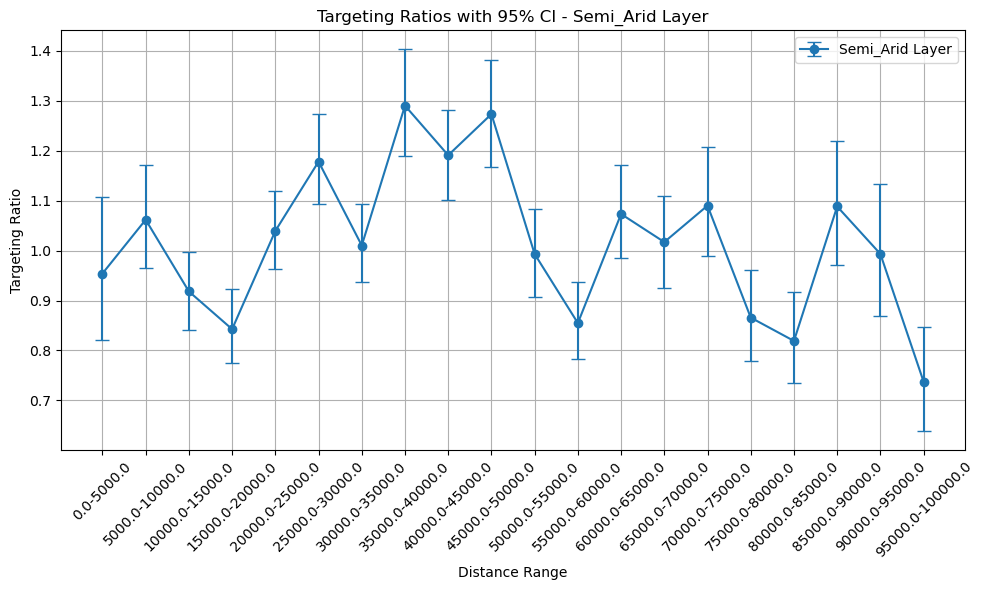

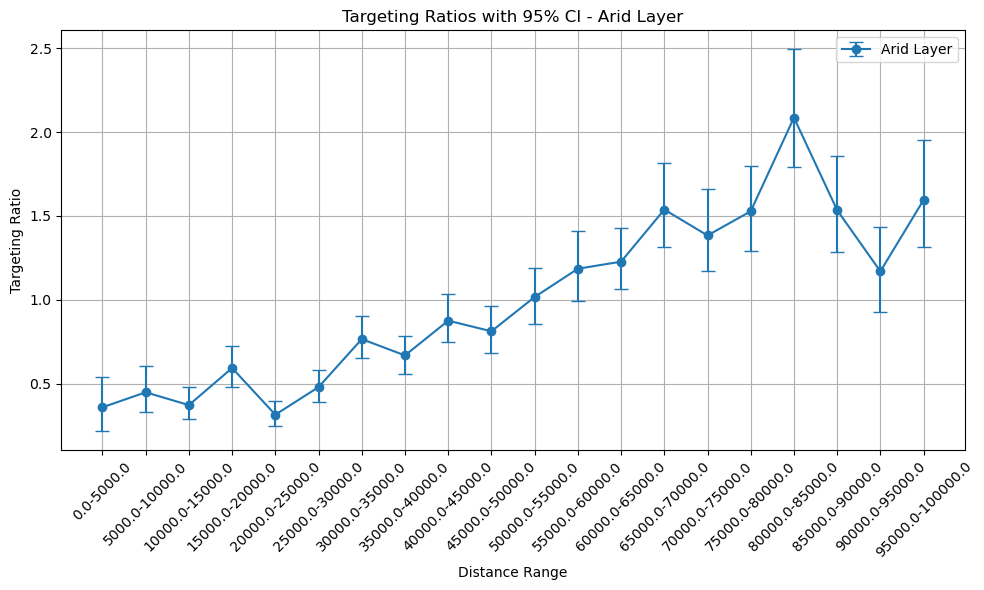

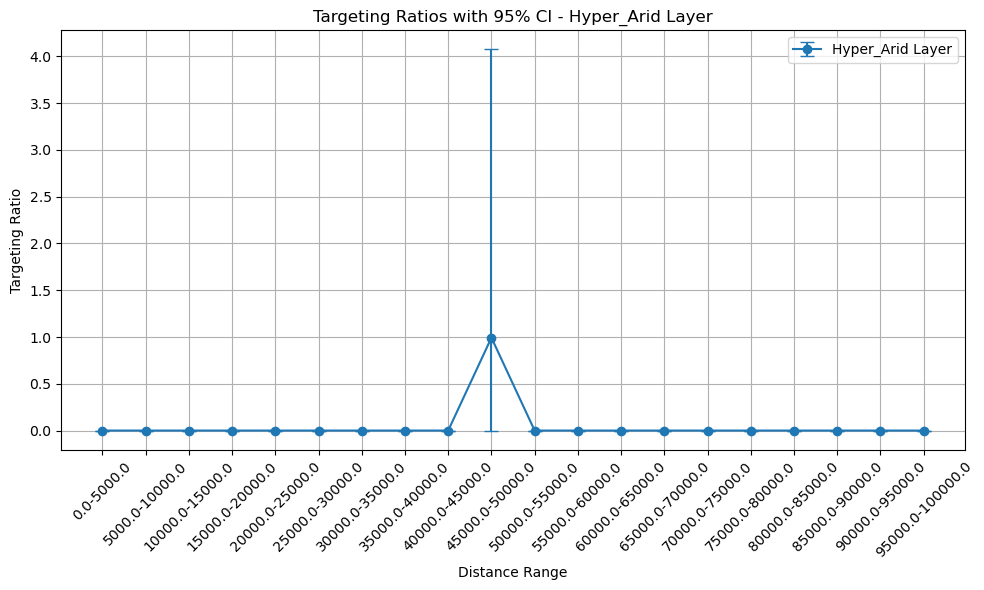

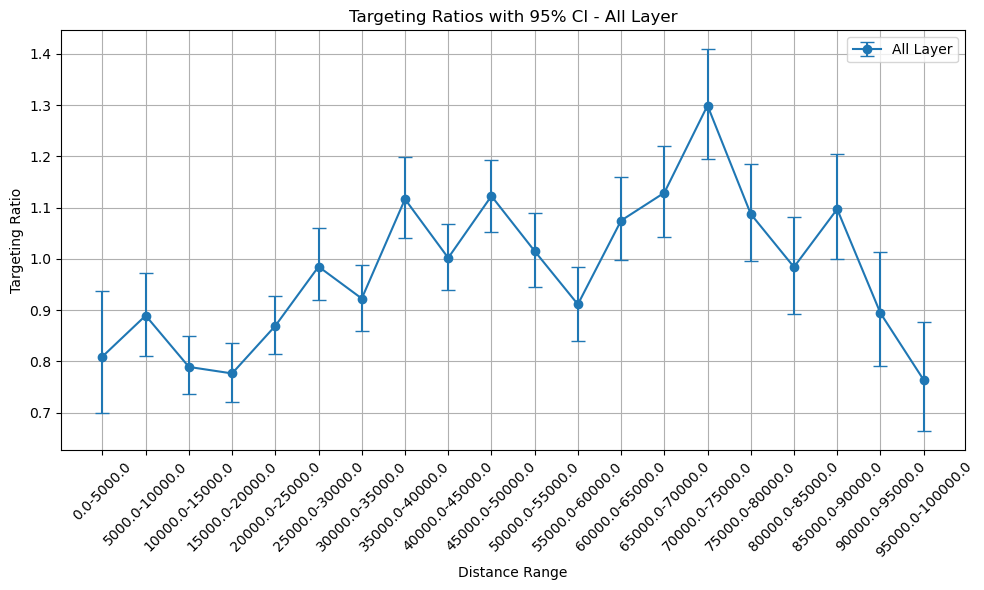

In [7]:
def bootstrap_targeting_ratio(numerator, denominator, num_bootstrap=10000):
    ratios = []
    for _ in range(num_bootstrap):
        boot_numerator = np.random.poisson(numerator)
        boot_denominator = np.random.poisson(denominator)
        if boot_denominator != 0:
            boot_ratio = boot_numerator / boot_denominator
        else:
            boot_ratio = np.nan
        ratios.append(boot_ratio)
    ratios = np.array(ratios)
    return np.nanpercentile(ratios, 2.5), np.nanpercentile(ratios, 97.5)

def calculate_targeting_ratios_with_bootstrap(cpis_classifications, proportion_irrigated_pixels, layers, num_bootstrap=1000):
    targeting_ratios_by_layer = {}
    confidence_intervals_by_layer = {}
    numerators_by_layer = {}
    denominators_by_layer = {}

    for layer in layers:
        print(f"Processing layer: {layer}")

        classifications = cpis_classifications.get(layer, {})
        proportions = proportion_irrigated_pixels.get(layer, {})

        targeting_ratios = {}
        confidence_intervals = {}
        numerators = {}
        denominators = {}

        for range_key in classifications.keys():
            print(f"Processing range: {range_key}")

            numerator = np.sum(classifications[range_key])
            print(f"Numerator: {numerator}")

            denominator = 0
            for iso3 in proportions.keys():
                if range_key in proportions[iso3]:
                    cpis_in_country = np.sum(layer_cpis_gdfs[layer]['ISO3'] == iso3)
                    percentage_in_range = proportions[iso3][range_key]
                    print(f'{denominator} + {cpis_in_country} * {percentage_in_range} =')
                    denominator += cpis_in_country * percentage_in_range
                    print(denominator)

            print(f"Denominator: {denominator}")

            targeting_ratio = numerator / denominator if denominator != 0 else np.nan

            # Bootstrap CI calculation
            if denominator != 0:
                ci_lower, ci_upper = bootstrap_targeting_ratio(numerator, denominator, num_bootstrap=num_bootstrap)
            else:
                ci_lower, ci_upper = np.nan, np.nan

            targeting_ratios[range_key] = targeting_ratio
            confidence_intervals[range_key] = (ci_lower, ci_upper)
            numerators[range_key] = numerator
            denominators[range_key] = denominator

        targeting_ratios_by_layer[layer] = targeting_ratios
        confidence_intervals_by_layer[layer] = confidence_intervals
        numerators_by_layer[layer] = numerators
        denominators_by_layer[layer] = denominators

        # Print the targeting ratios and CIs for the current layer
        print(f"Targeting Ratios for {layer} layer:")
        for range_key, ratio in targeting_ratios.items():
            ci = confidence_intervals[range_key]
            print(f"{range_key}: {ratio:.4f} (95% CI: {ci[0]:.4f}, {ci[1]:.4f})")

    return targeting_ratios_by_layer, confidence_intervals_by_layer, numerators_by_layer, denominators_by_layer

def plot_targeting_ratios_with_ci(targeting_ratios_by_layer, confidence_intervals_by_layer):
    for layer, ratios in targeting_ratios_by_layer.items():
        ranges = list(ratios.keys())
        ratio_values = list(ratios.values())
        
        # Extracting the CIs
        ci_lower = [confidence_intervals_by_layer[layer][range_key][0] for range_key in ranges]
        ci_upper = [confidence_intervals_by_layer[layer][range_key][1] for range_key in ranges]
        
        # Midpoint for the error bars
        error = np.array([ratio_values - np.array(ci_lower), np.array(ci_upper) - ratio_values])

        plt.figure(figsize=(10, 6))
        plt.errorbar(ranges, ratio_values, yerr=error, fmt='-o', capsize=5, label=f'{layer} Layer')
        plt.xlabel('Distance Range')
        plt.ylabel('Targeting Ratio')
        plt.title(f'Targeting Ratios with 95% CI - {layer} Layer')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Call the function with your data
targeting_ratios_by_layer, confidence_intervals_by_layer, numerators_by_layer, denominators_by_layer = calculate_targeting_ratios_with_bootstrap(cpis_classifications, proportion_irrigated_pixels, layers)

# Now you can access the targeting_ratios_by_layer, confidence_intervals_by_layer, numerators_by_layer, and denominators_by_layer directly

# Plot the results
plot_targeting_ratios_with_ci(targeting_ratios_by_layer, confidence_intervals_by_layer)


Creating figures for Semi_Arid layer...
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]


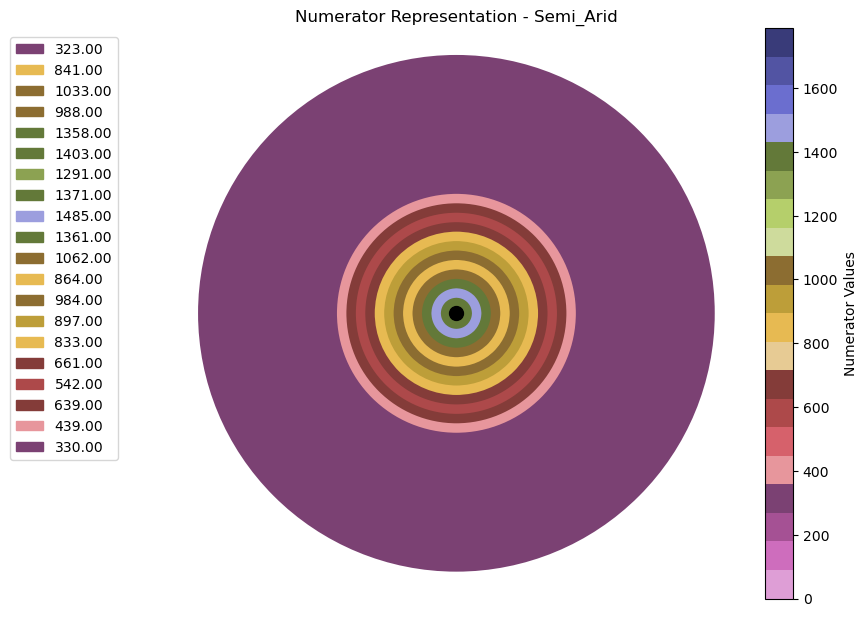

[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]


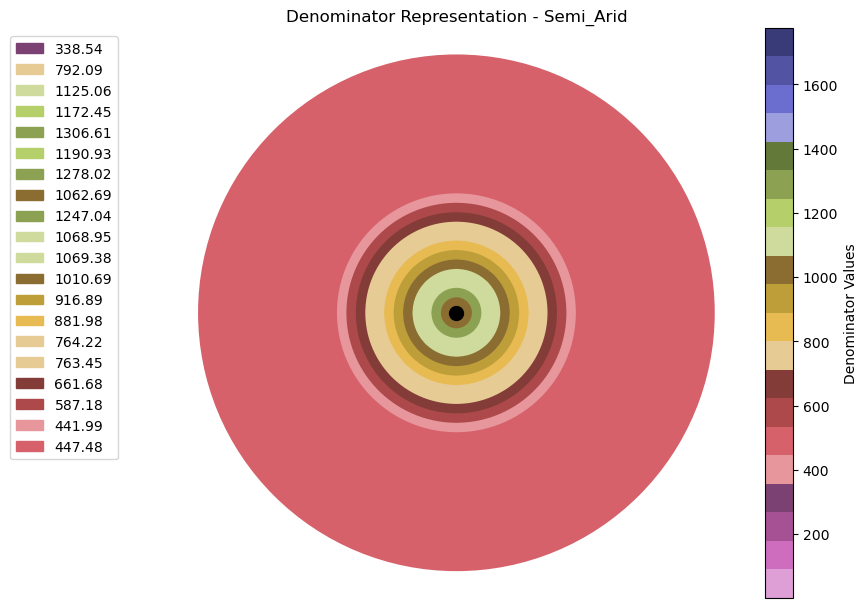

[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]


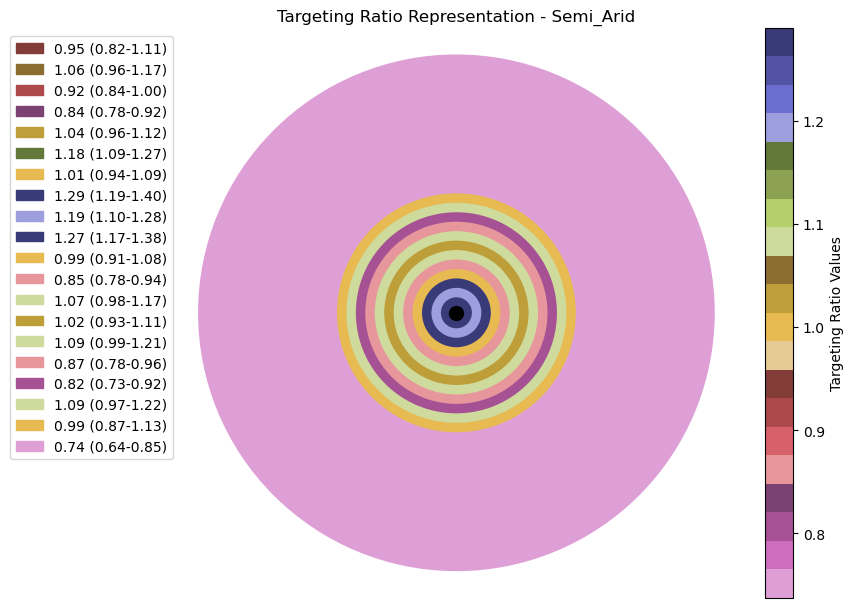

Creating figures for Arid layer...
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]


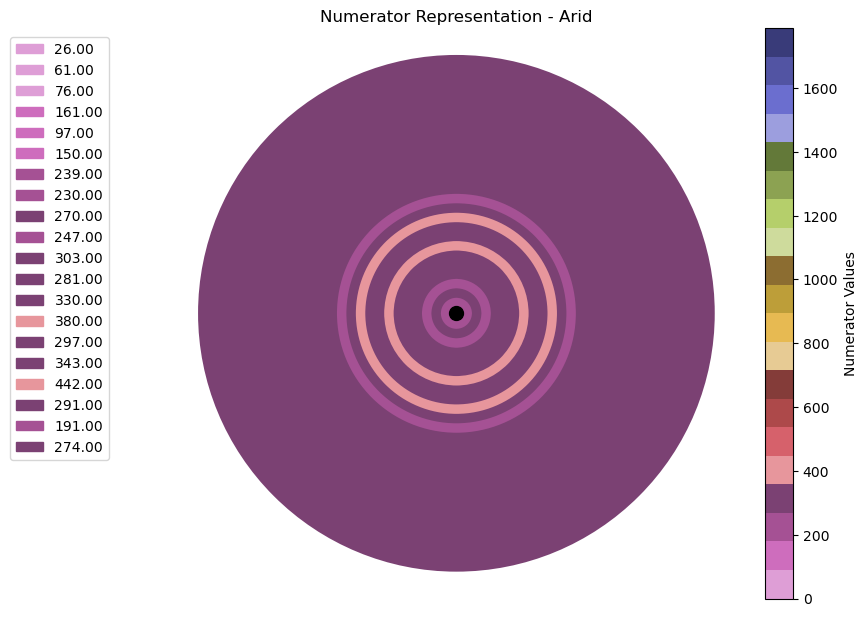

[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]


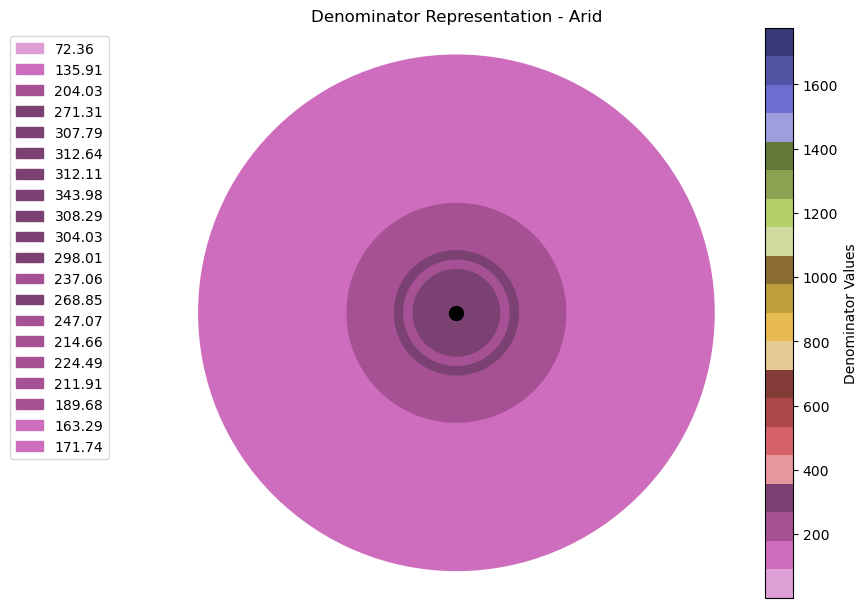

[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]


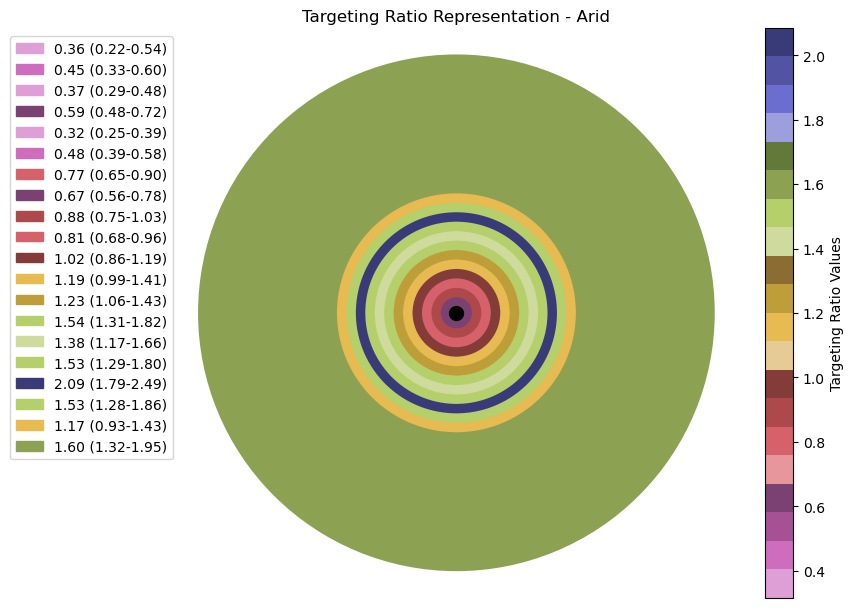

Creating figures for Hyper_Arid layer...
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]


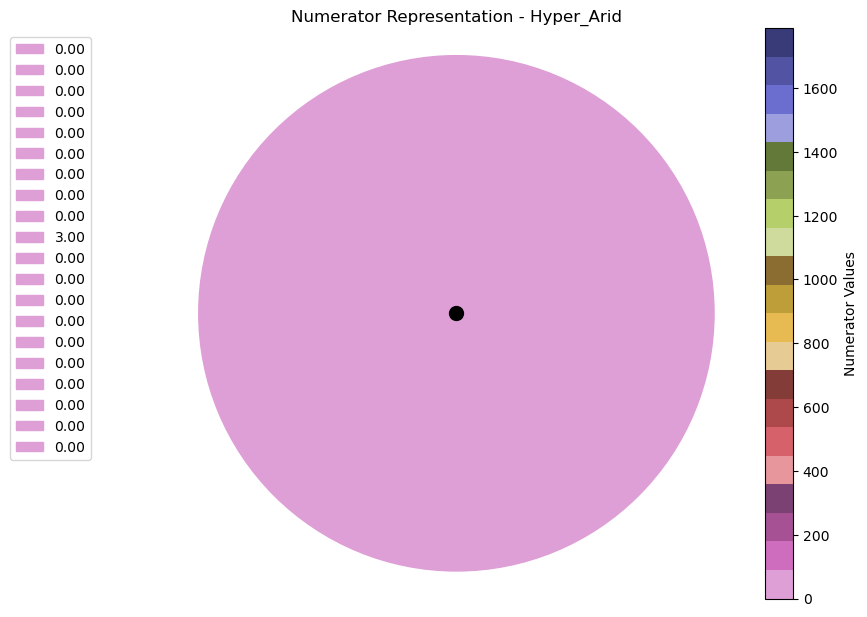

[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]


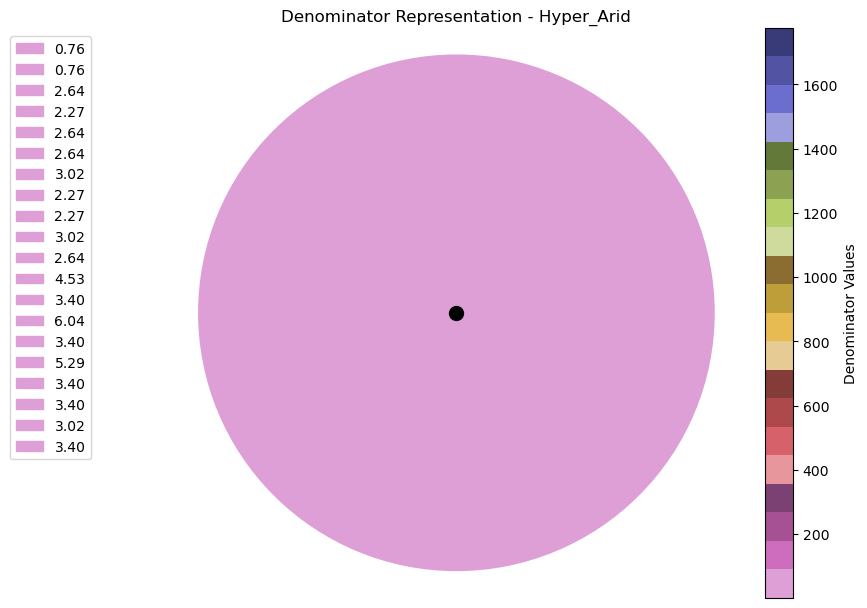

[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]


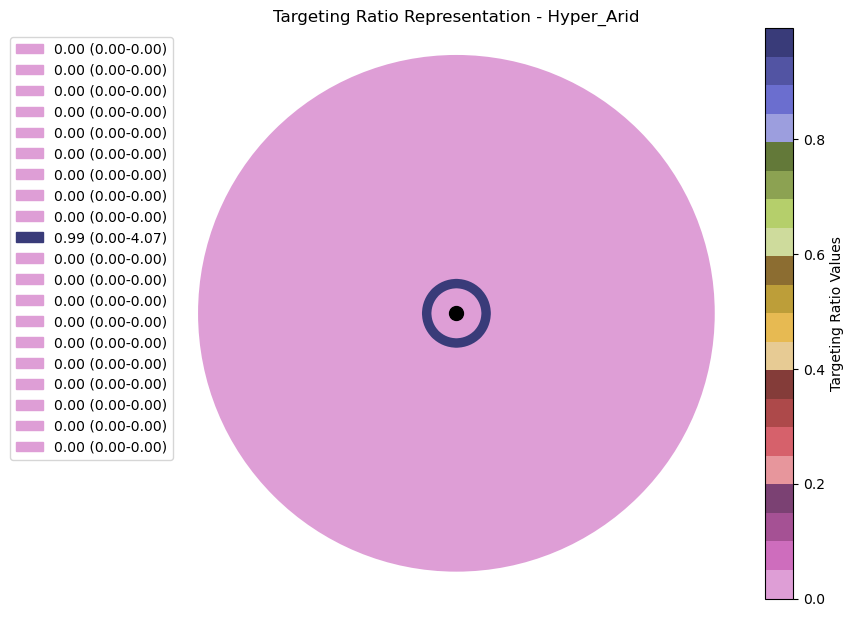

Creating figures for All layer...
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]


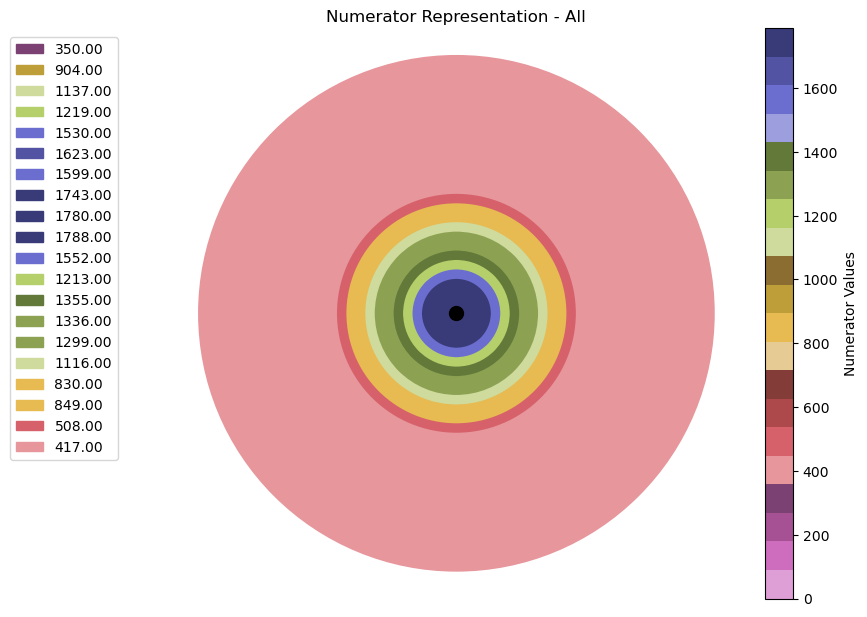

[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]


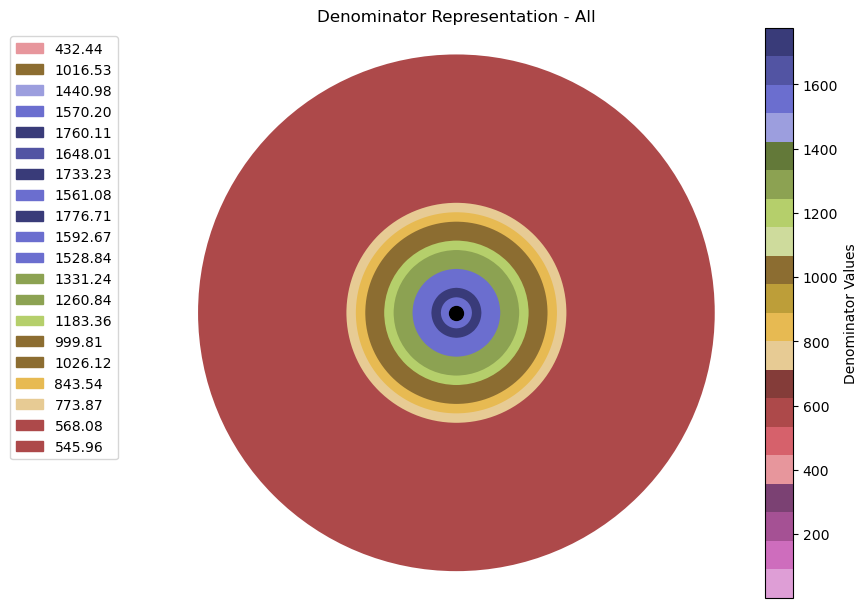

[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]


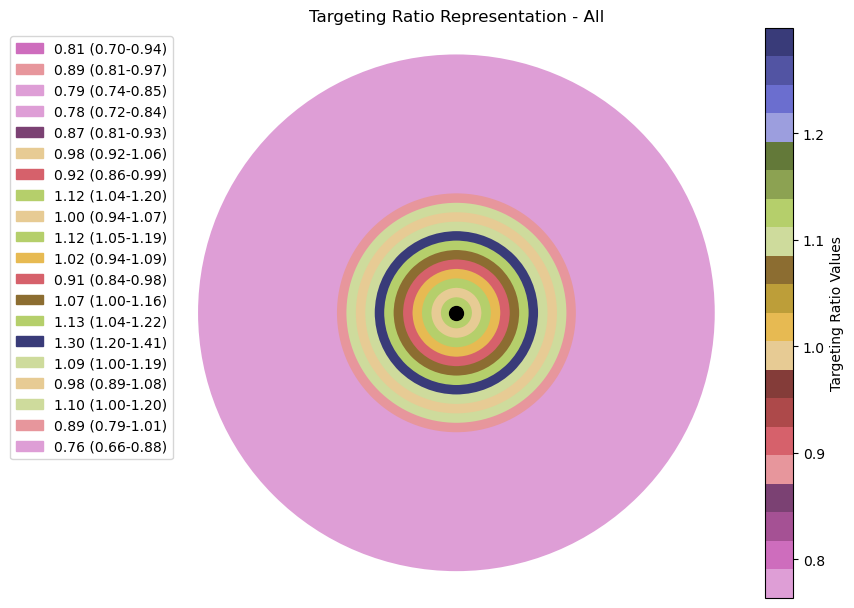

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

#def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    #new_cmap = mcolors.LinearSegmentedColormap.from_list(
        #f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        #cmap(np.linspace(minval, maxval, n))
    #)
    #return new_cmap

# Example of truncating the 'viridis' colormap to remove the last 10% of the colors
#truncated_cmap = truncate_colormap(plt.get_cmap('gnuplot2'), 0.15, 0.9)
truncated_cmap = 'tab20b_r'

# Function to plot target-like figures with consistent color bar bounds
def plot_target_like_figure(values, title, layer, legend_title, vmin, vmax, num_rings=20, color_map=truncated_cmap, confidence_intervals=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Define color map and normalize it based on the consistent vmin and vmax
    cmap = plt.get_cmap(color_map)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # Plot a background circle with the color of the innermost ring
    background_color = cmap(norm(values[0]))
    background_circle = plt.Circle((0, 0), 100 * num_rings * 1.2, color=background_color, zorder=-1)
    ax.add_artist(background_circle)
    
    # Define the thickness for the rings
    ring_widths = np.diff([0] + [100 * (i + 1) for i in range(num_rings)])

    print(ring_widths)
    
    # Plot each ring
    legend_patches = []
    for i, value in enumerate(values):
        radius = 100 * (i + 1)
        ring_color = cmap(norm(value))
        ring = plt.Circle((0, 0), radius, color=ring_color, fill=False, linewidth=ring_widths[i], zorder=i+1)
        ax.add_artist(ring)
        
        # Create a legend entry
        if confidence_intervals:
            ci_lower, ci_upper = confidence_intervals[i]
            legend_label = f'{value:.2f} ({ci_lower:.2f}-{ci_upper:.2f})'
        else:
            legend_label = f'{value:.2f}'
        legend_patches.append(mpatches.Patch(color=ring_color, label=legend_label))
    
    # Center point representing the dam
    plt.plot(0, 0, 'ko', markersize=10, markeredgecolor='black', zorder=num_rings+1)

    # Set limits to be slightly larger than the maximum radius to avoid clipping
    max_radius = 100 * num_rings
    zoom_out_factor = 1.5  # Zoom out by 50%
    ax.set_xlim(-max_radius * zoom_out_factor, max_radius * zoom_out_factor)
    ax.set_ylim(-max_radius * zoom_out_factor, max_radius * zoom_out_factor)
    ax.set_aspect('equal')  # Ensures the aspect ratio is equal to make the circles look correct
    ax.axis('off')

    # Add the custom legend on the left side
    ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(-0.3, 1))

    # Add color bar with consistent vmin and vmax
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(legend_title)

    # Set title
    plt.title(f'{title} - {layer}')

    plt.show()

# Find global min and max for numerators and denominators
numerator_min = min([min(numerators_by_layer[layer].values()) for layer in layers])
numerator_max = max([max(numerators_by_layer[layer].values()) for layer in layers])

denominator_min = min([min(denominators_by_layer[layer].values()) for layer in layers])
denominator_max = max([max(denominators_by_layer[layer].values()) for layer in layers])

# Plotting the figures for each layer with consistent color bar bounds
for layer in layers:
    print(f"Creating figures for {layer} layer...")
    
    # Numerator figure
    num_values = list(numerators_by_layer[layer].values())
    plot_target_like_figure(num_values, "Numerator Representation", layer, "Numerator Values", vmin=numerator_min, vmax=numerator_max)

    # Denominator figure
    denom_values = list(denominators_by_layer[layer].values())
    plot_target_like_figure(denom_values, "Denominator Representation", layer, "Denominator Values", vmin=denominator_min, vmax=denominator_max)
    
    # Targeting ratio figure (if needed, consistent bounds can be applied similarly)
    ratio_values = list(targeting_ratios_by_layer[layer].values())
    ci_values = list(confidence_intervals_by_layer[layer].values())
    plot_target_like_figure(ratio_values, "Targeting Ratio Representation", layer, "Targeting Ratio Values", vmin=min(ratio_values), vmax=max(ratio_values), confidence_intervals=ci_values)

Creating figures for Semi_Arid layer...


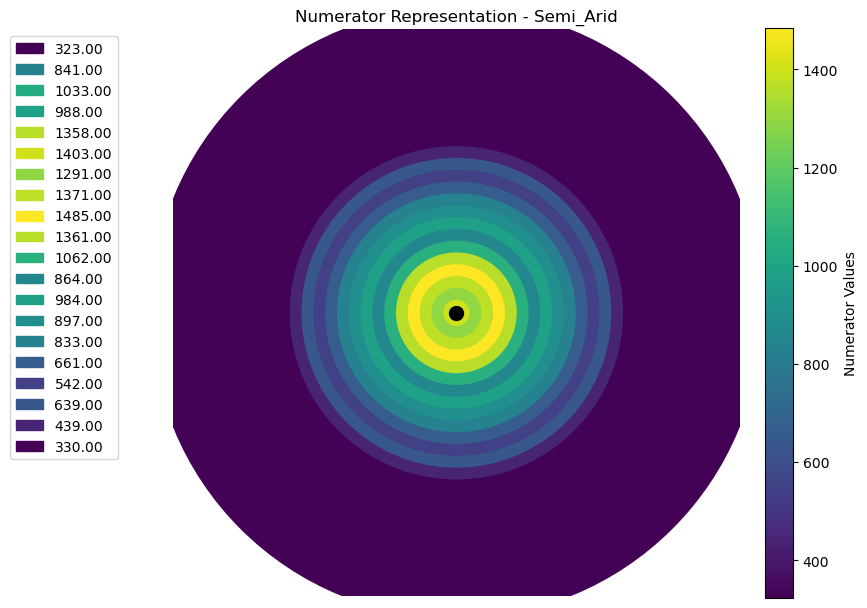

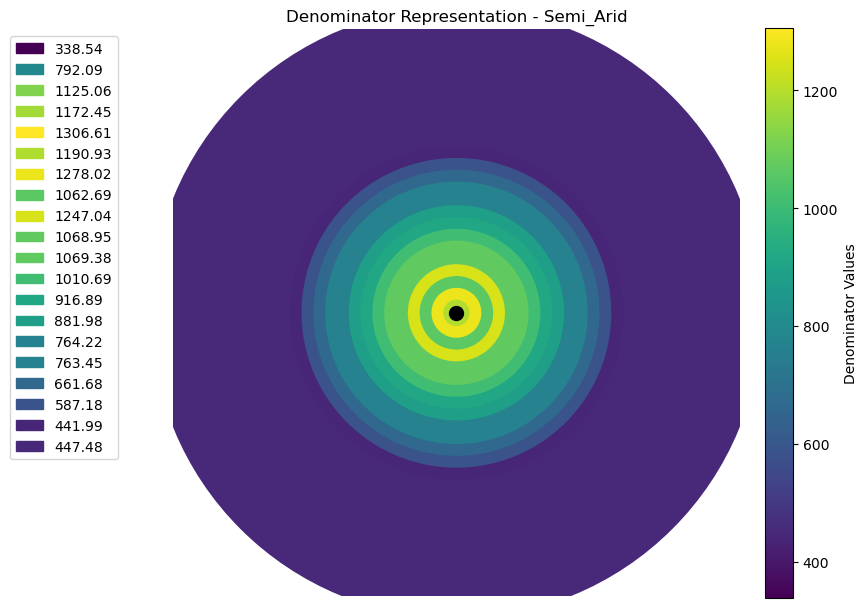

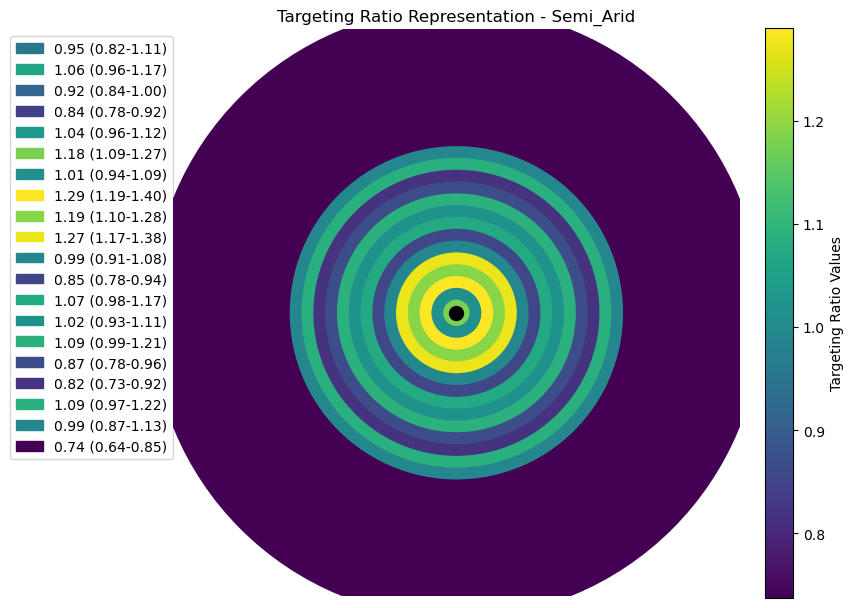

Creating figures for Arid layer...


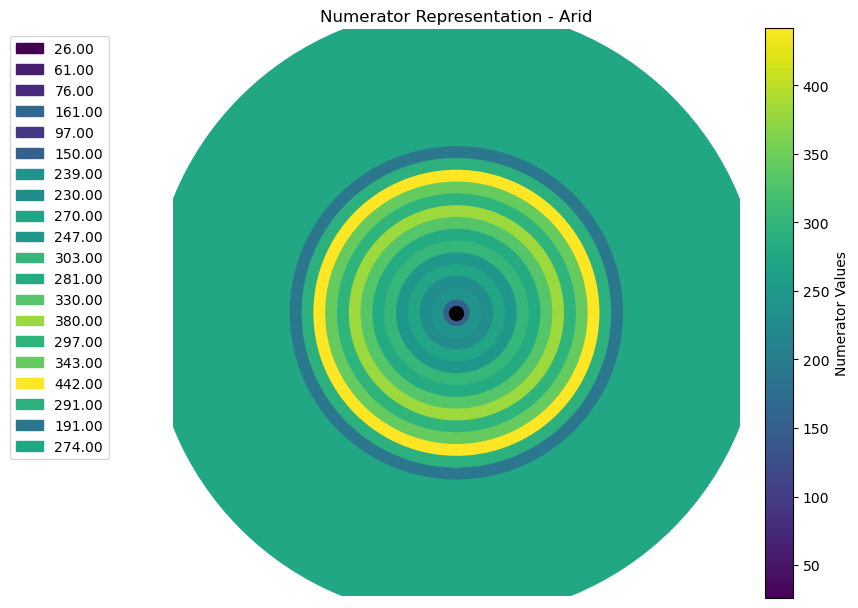

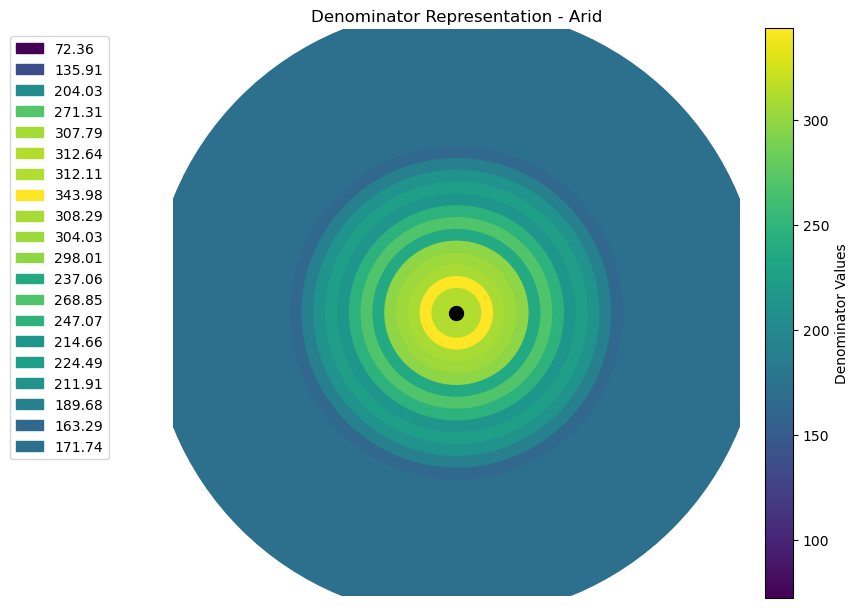

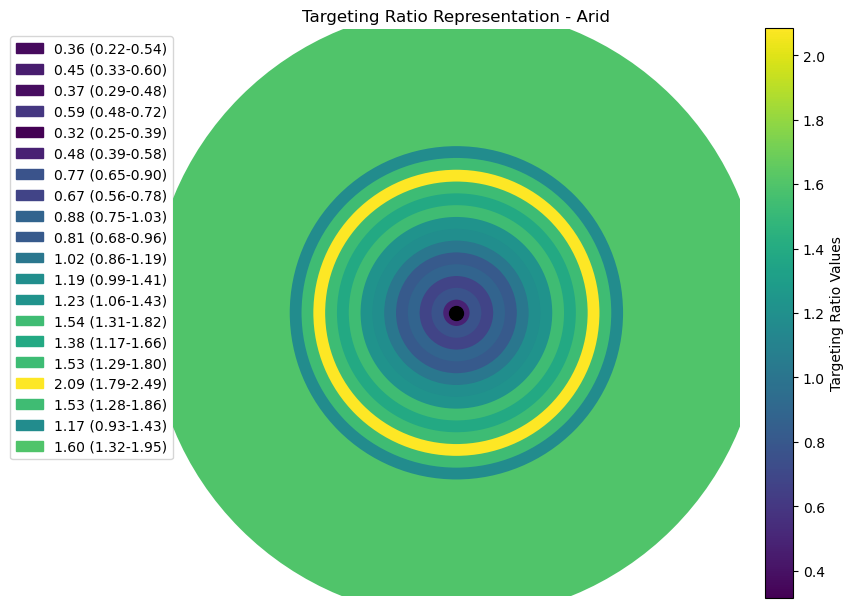

Creating figures for Hyper_Arid layer...


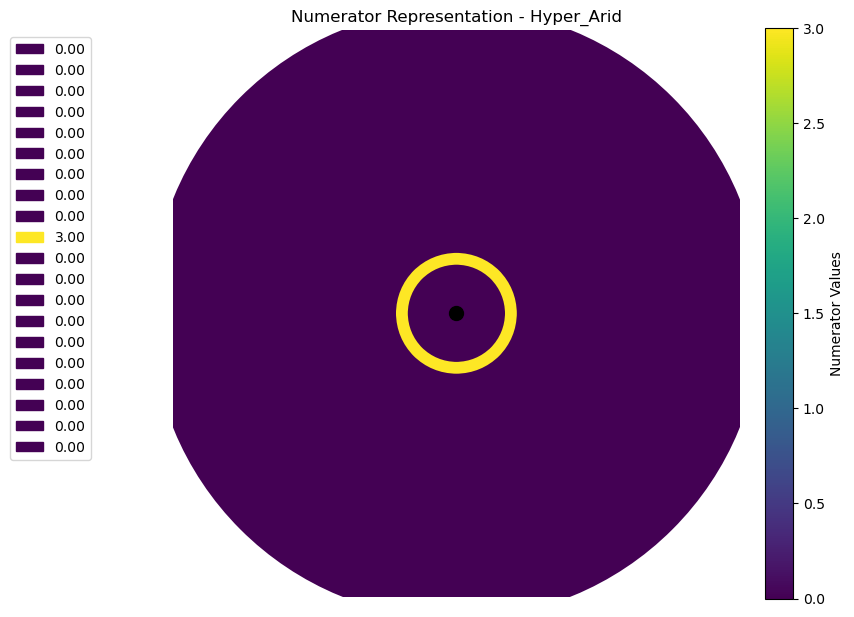

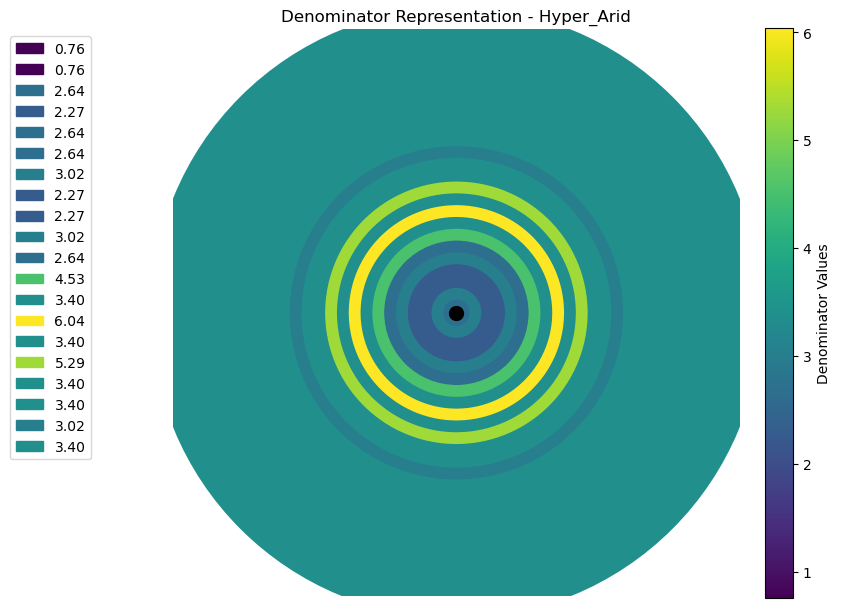

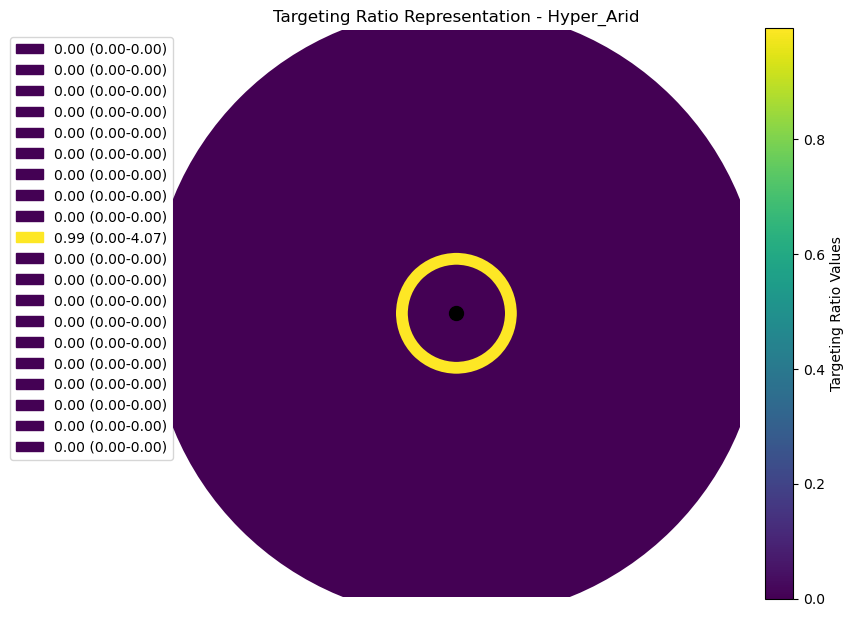

Creating figures for All layer...


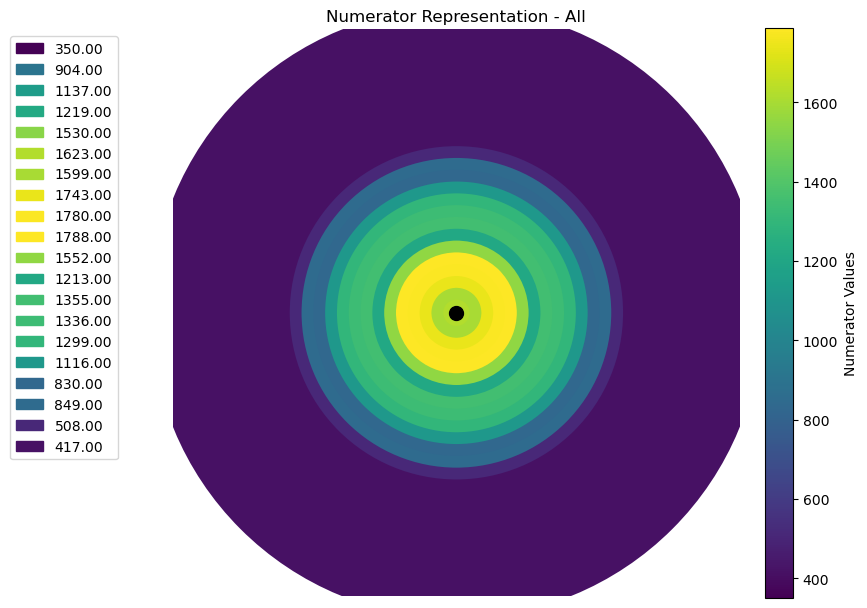

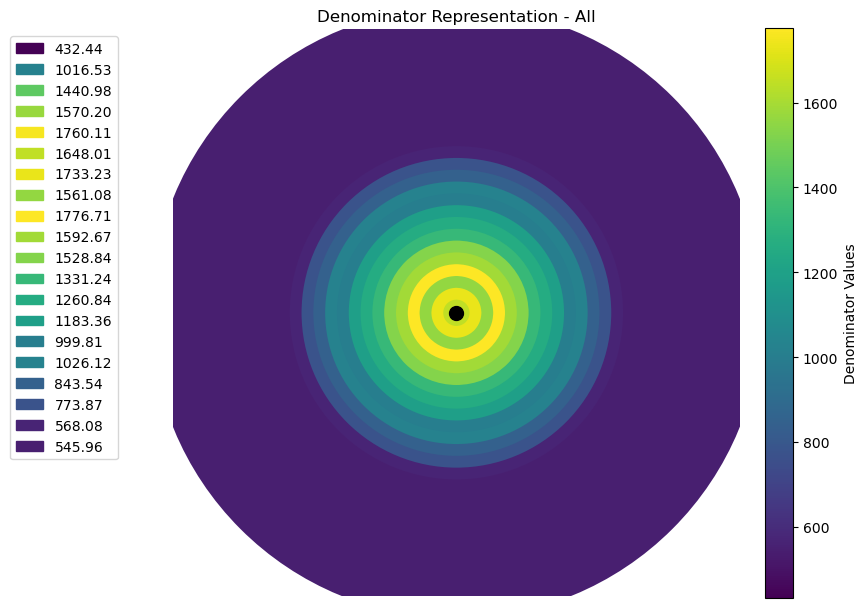

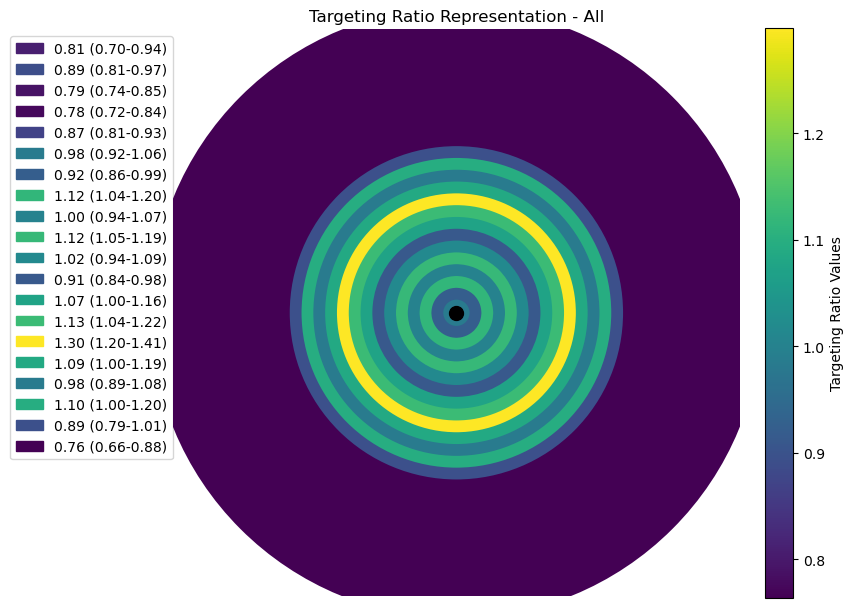

In [9]:
#THIS IS THE GOOD ONE

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Function to plot target-like figures with correct scaling and aspect ratio, with custom legends
def plot_target_like_figure(values, title, layer, legend_title, num_rings=20, color_map='viridis', confidence_intervals=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Define color map and normalize it based on the values
    cmap = plt.get_cmap(color_map)
    norm = mcolors.Normalize(vmin=min(values), vmax=max(values))

    # Plot a background circle with the color of the innermost ring
    background_color = cmap(norm(values[0]))
    background_circle = plt.Circle((0, 0), 100 * num_rings * 1.2, color=background_color, zorder=-1)
    ax.add_artist(background_circle)
    
    # Define the thickness for the rings
    ring_widths = np.diff([0] + [100 * (i + 1) for i in range(num_rings)])
    
    # Plot each ring
    legend_patches = []
    for i, value in enumerate(values):
        radius = 100 * (i + 1)
        ring_color = cmap(norm(value))
        ring = plt.Circle((0, 0), radius, color=ring_color, fill=False, linewidth=ring_widths[i], zorder=i+1)
        ax.add_artist(ring)
        
        # Create a legend entry
        if confidence_intervals:
            ci_lower, ci_upper = confidence_intervals[i]
            legend_label = f'{value:.2f} ({ci_lower:.2f}-{ci_upper:.2f})'
        else:
            legend_label = f'{value:.2f}'
        legend_patches.append(mpatches.Patch(color=ring_color, label=legend_label))
    
    # Center point representing the dam
    plt.plot(0, 0, 'ko', markersize=10, markeredgecolor='black', zorder=num_rings+1)

    # Set limits to be slightly larger than the maximum radius to avoid clipping
    max_radius = 100 * num_rings
    zoom_out_factor = 1.2  # Zoom out by 20%
    ax.set_xlim(-max_radius * zoom_out_factor, max_radius * zoom_out_factor)
    ax.set_ylim(-max_radius * zoom_out_factor, max_radius * zoom_out_factor)
    ax.set_aspect('equal')  # Ensures the aspect ratio is equal to make the circles look correct
    ax.axis('off')

    # Add the custom legend on the left side
    ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(-0.3, 1))

    # Add color bar (optional)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(legend_title)

    # Set title
    plt.title(f'{title} - {layer}')

    plt.show()

# Plotting the figures for each layer
for layer in layers:
    print(f"Creating figures for {layer} layer...")
    
    # Numerator figure
    num_values = list(numerators_by_layer[layer].values())
    plot_target_like_figure(num_values, "Numerator Representation", layer, "Numerator Values")

    # Denominator figure
    denom_values = list(denominators_by_layer[layer].values())
    plot_target_like_figure(denom_values, "Denominator Representation", layer, "Denominator Values")
    
    # Targeting ratio figure
    ratio_values = list(targeting_ratios_by_layer[layer].values())
    ci_values = list(confidence_intervals_by_layer[layer].values())
    plot_target_like_figure(ratio_values, "Targeting Ratio Representation", layer, "Targeting Ratio Values", confidence_intervals=ci_values)


Creating figures for Semi_Arid layer...


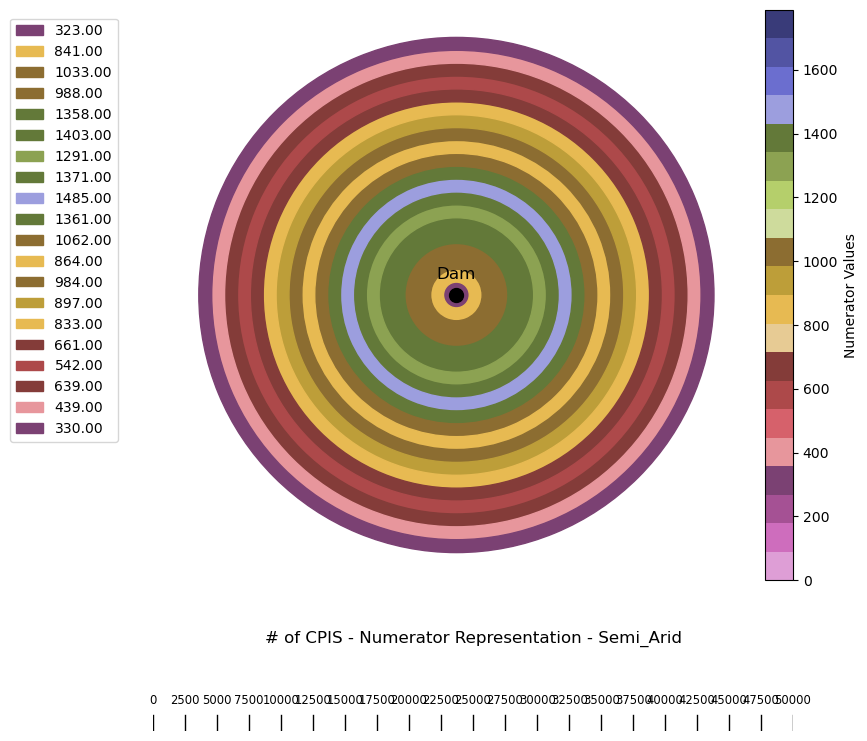

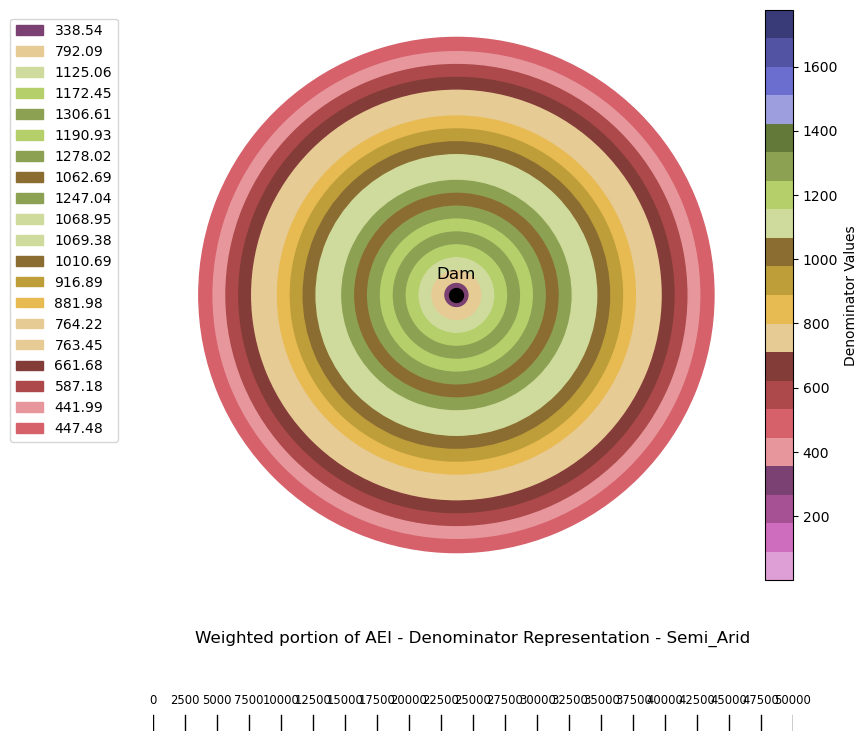

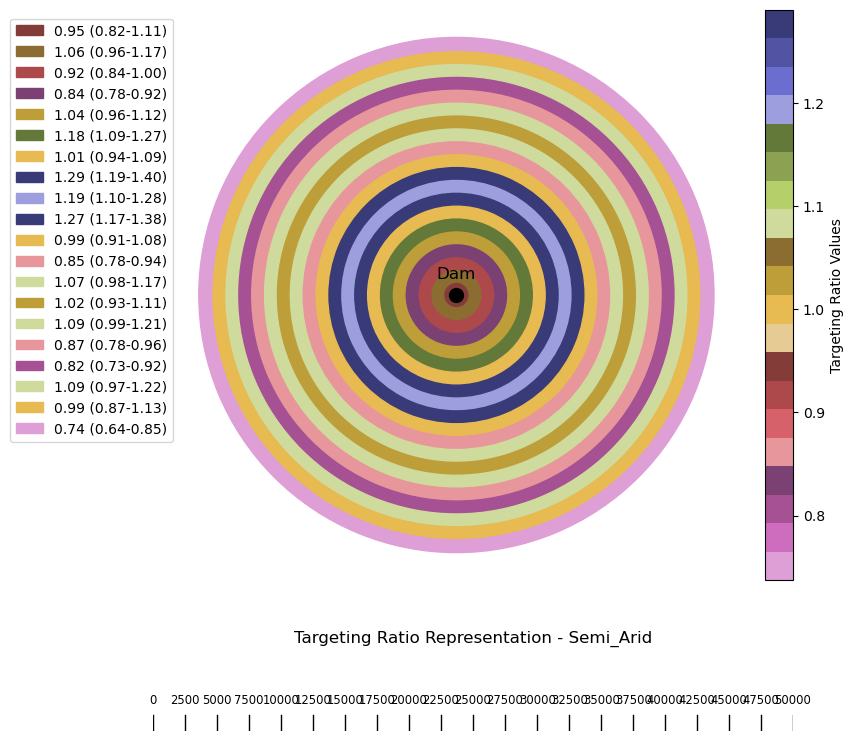

Creating figures for Arid layer...


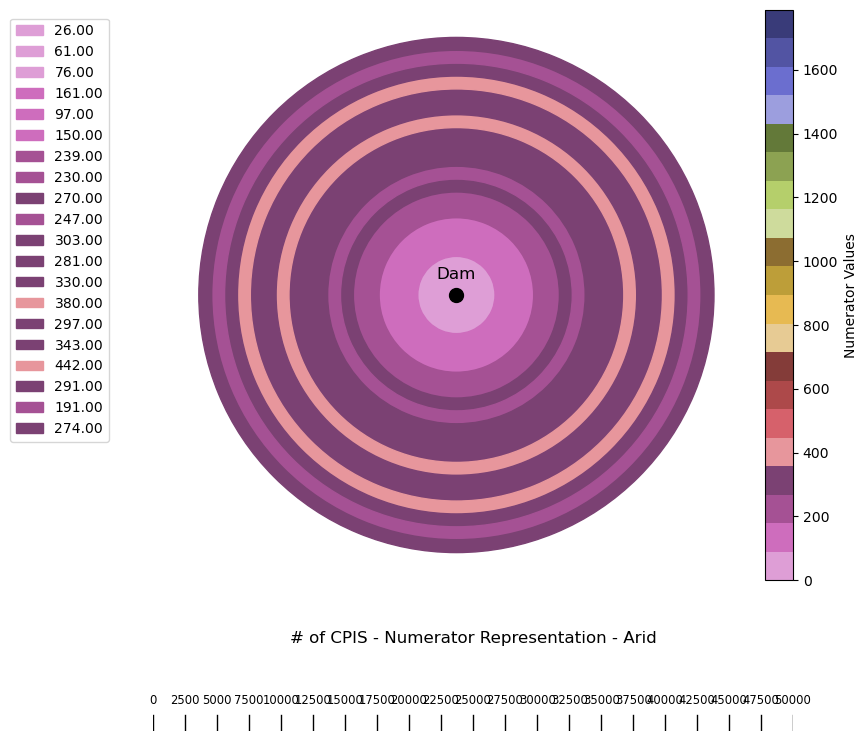

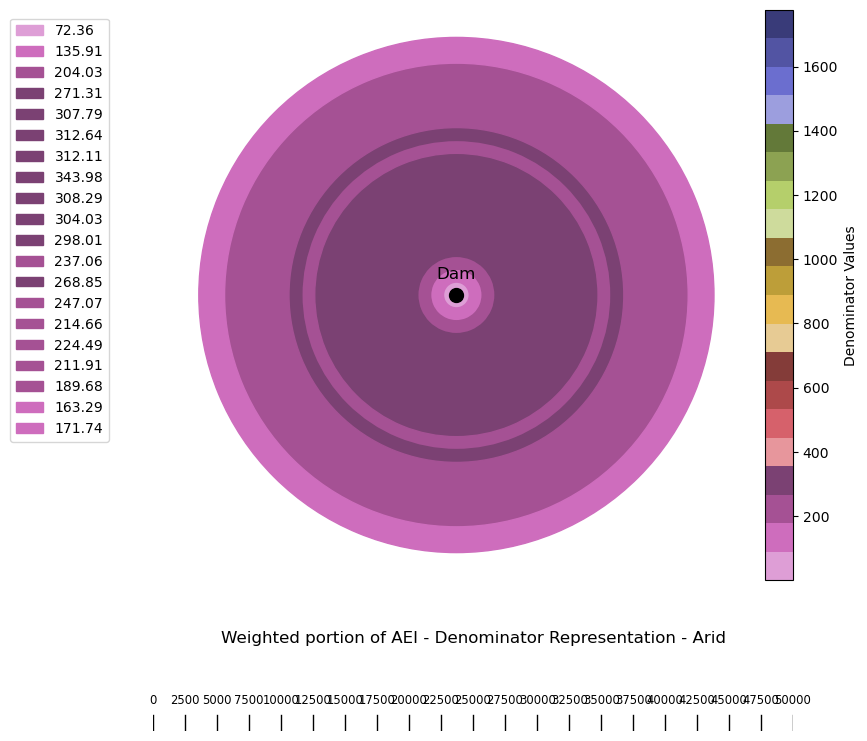

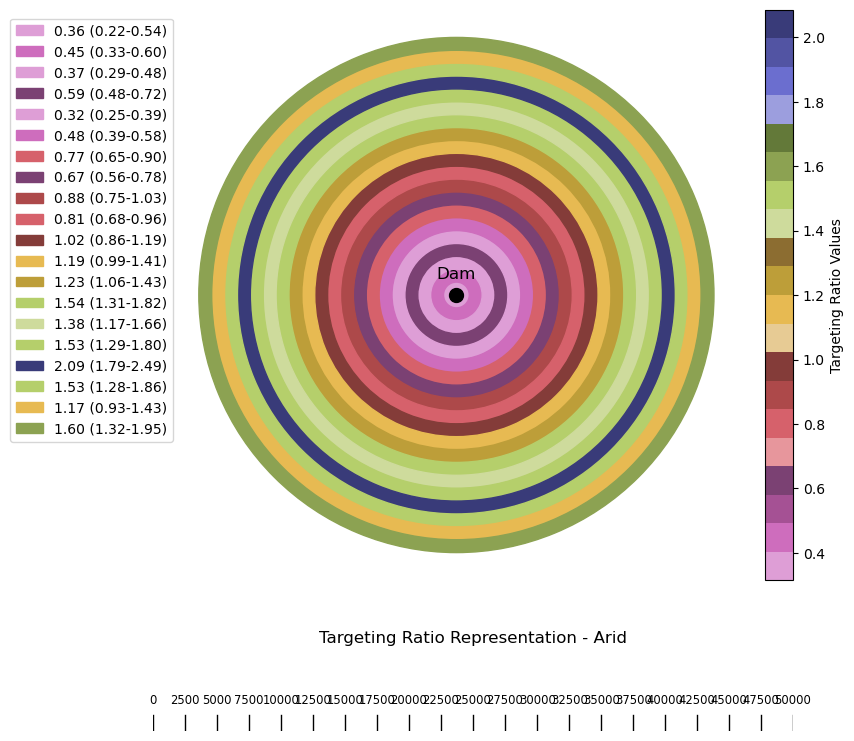

Creating figures for Hyper_Arid layer...


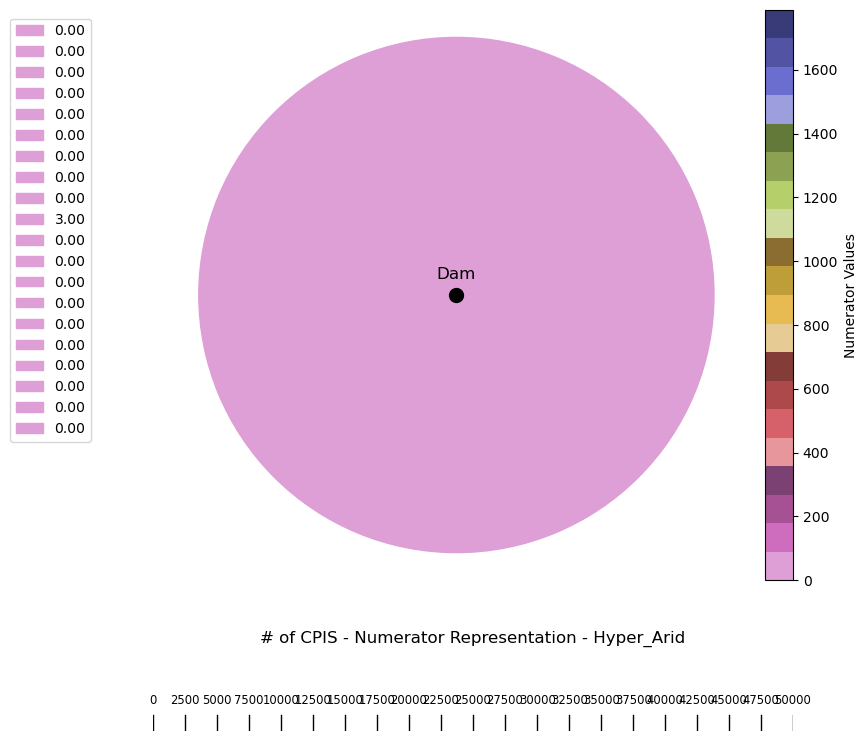

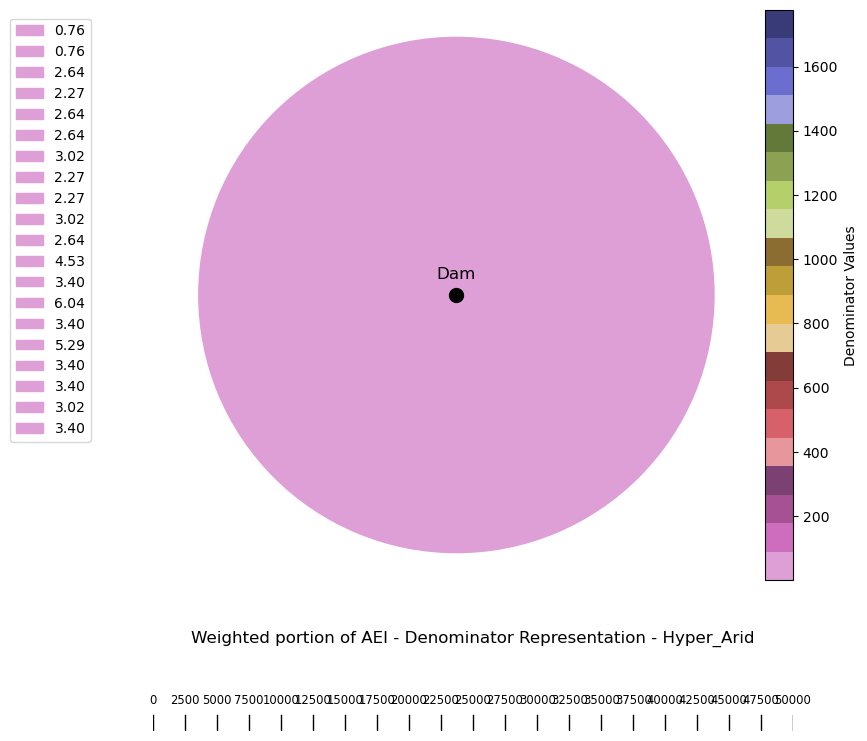

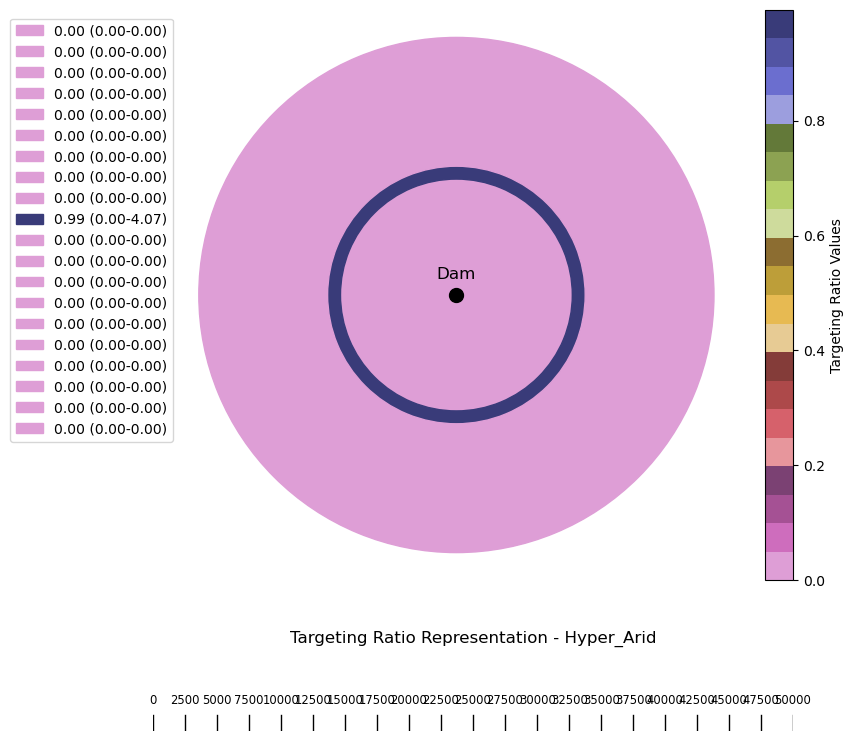

Creating figures for All layer...


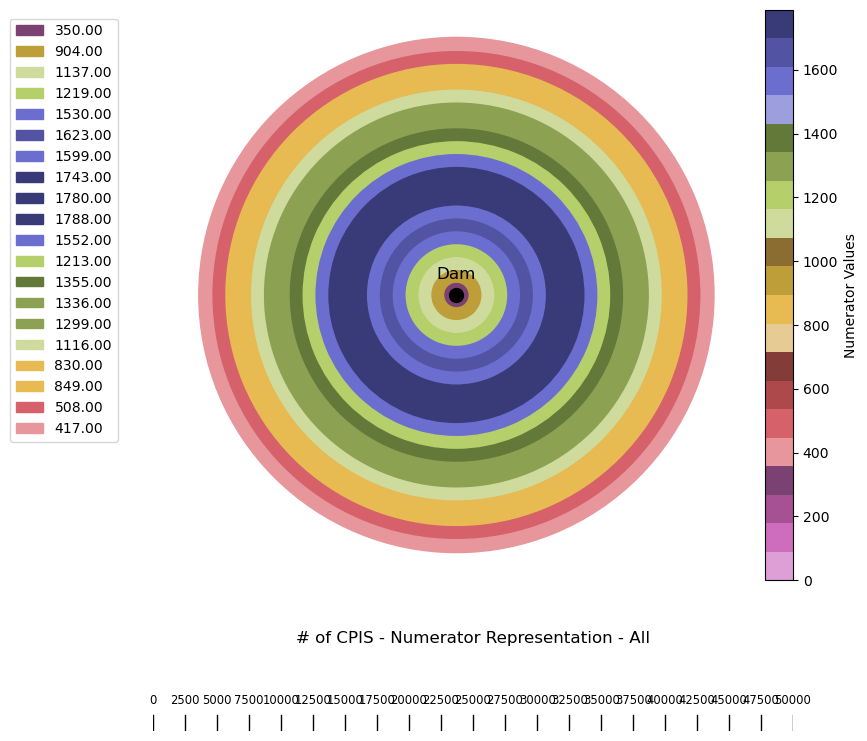

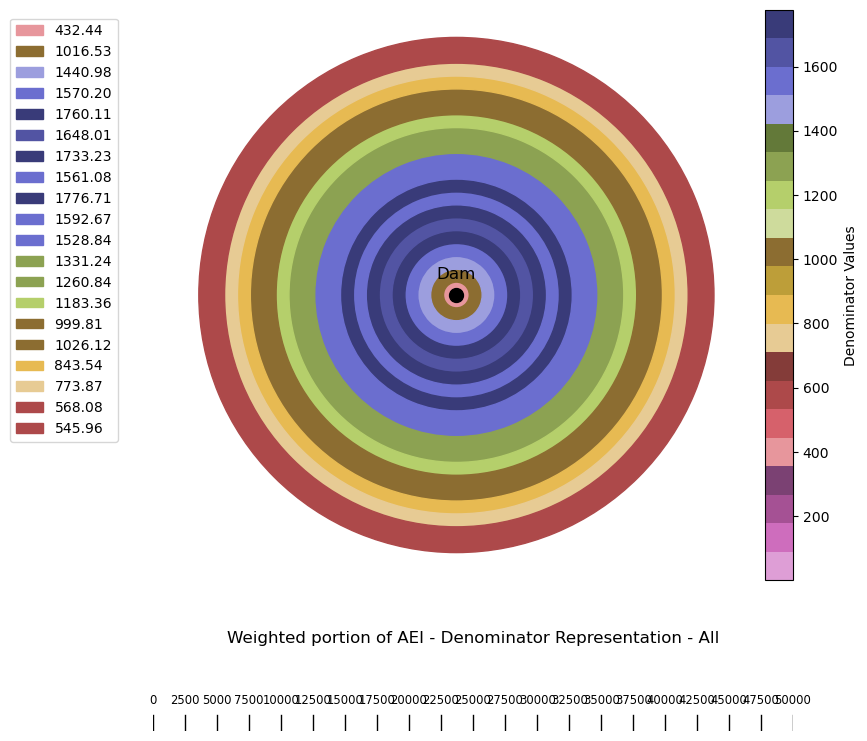

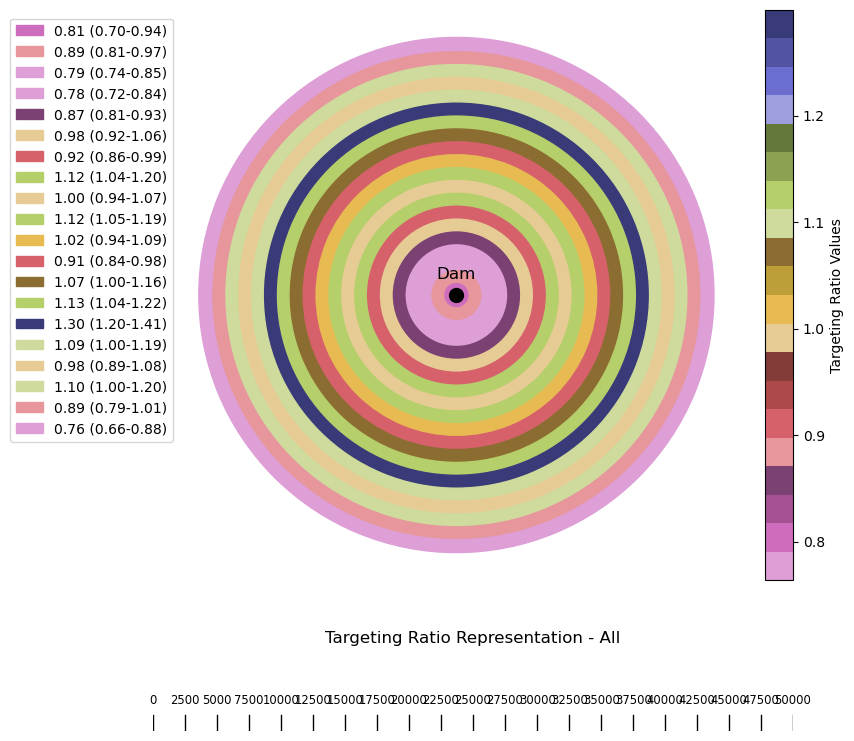

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Define the distance ranges for the 20 intervals
interval_edges = np.linspace(0, 50000, num=21)  # 21 edges define 20 intervals
distance_ranges = [(interval_edges[i], interval_edges[i+1]) for i in range(len(interval_edges)-1)]

# Define a custom colormap
cmap_name = 'tab20b_r'

# Function to plot target-like figures with consistent color bar bounds
def plot_target_like_figure(values, title, layer, legend_title, vmin, vmax, distance_ranges, color_map=cmap_name, confidence_intervals=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Define color map and normalize it based on the consistent vmin and vmax
    cmap = plt.get_cmap(color_map)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # Calculate ring widths based on the distance intervals
    ring_widths = [upper - lower for lower, upper in distance_ranges]

    # Initialize the starting radius
    current_radius = 0
    
    # Plot each ring as an annulus
    legend_patches = []
    for i, value in enumerate(values):
        # Calculate the outer and inner radius for the current ring
        inner_radius = current_radius
        outer_radius = current_radius + ring_widths[i]
        ring_color = cmap(norm(value))
        
        # Draw the ring as a Wedge (an annulus segment)
        ring = mpatches.Wedge((0, 0), outer_radius, 0, 360, width=ring_widths[i], color=ring_color, zorder=i+1)
        ax.add_artist(ring)
        
        # Update the current radius for the next ring
        current_radius = outer_radius
        
        # Create a legend entry
        if confidence_intervals:
            ci_lower, ci_upper = confidence_intervals[i]
            legend_label = f'{value:.2f} ({ci_lower:.2f}-{ci_upper:.2f})'
        else:
            legend_label = f'{value:.2f}'
        legend_patches.append(mpatches.Patch(color=ring_color, label=legend_label))
    
    # Center point representing the dam
    plt.plot(0, 0, 'ko', markersize=10, markeredgecolor='black', zorder=len(values)+1)

     # Label the center point as "Dam" above the point
    ax.text(0, current_radius * 0.05, 'Dam', fontsize=12, ha='center', va='bottom', color='black', zorder=len(values)+2)

    # Set limits to be slightly larger than the maximum radius to avoid clipping
    max_radius = sum(ring_widths)
    ax.set_xlim(-max_radius * 1.1, max_radius * 1.1)  # Adding a small buffer
    ax.set_ylim(-max_radius * 1.1, max_radius * 1.1)
    ax.set_aspect('equal')  # Ensures the aspect ratio is equal to make the circles look correct
    ax.axis('off')

    # Add the custom legend on the left side
    ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(-0.3, 1))

    # Add color bar with consistent vmin and vmax
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(legend_title)

    # Add an axis at the bottom to label some radii
    ax_radii = fig.add_axes([0.1, -0.05, 0.8, 0.1])  # Create a new axis below the main plot
    ax_radii.set_xlim(0, max_radius)
    ax_radii.set_ylim(0, 1)
    ax_radii.axis('off')

    # Add 21 evenly spaced tally marks
    for i in range(21):
        radius = max_radius * i / 20  # Evenly spaced
        ax_radii.plot([radius, radius], [0, 0.2], 'k-', lw=1)
        ax_radii.text(radius, 0.3, f'{radius:.0f}', ha='center', va='bottom', fontsize='small')


    # Set title
    plt.title(f'{title} - {layer}')

    plt.show()

# Find global min and max for numerators and denominators
numerator_min = min([min(numerators_by_layer[layer].values()) for layer in layers])
numerator_max = max([max(numerators_by_layer[layer].values()) for layer in layers])

denominator_min = min([min(denominators_by_layer[layer].values()) for layer in layers])
denominator_max = max([max(denominators_by_layer[layer].values()) for layer in layers])

# Plotting the figures for each layer with consistent color bar bounds
for layer in layers:
    print(f"Creating figures for {layer} layer...")
    
    # Numerator figure
    num_values = list(numerators_by_layer[layer].values())
    plot_target_like_figure(num_values, "# of CPIS - Numerator Representation", layer, "Numerator Values", vmin=numerator_min, vmax=numerator_max, distance_ranges=distance_ranges)

    # Denominator figure
    denom_values = list(denominators_by_layer[layer].values())
    plot_target_like_figure(denom_values, "Weighted portion of AEI - Denominator Representation", layer, "Denominator Values", vmin=denominator_min, vmax=denominator_max, distance_ranges=distance_ranges)
    
    # Targeting ratio figure (if needed, consistent bounds can be applied similarly)
    ratio_values = list(targeting_ratios_by_layer[layer].values())
    ci_values = list(confidence_intervals_by_layer[layer].values())
    plot_target_like_figure(ratio_values, "Targeting Ratio Representation", layer, "Targeting Ratio Values", vmin=min(ratio_values), vmax=max(ratio_values), distance_ranges=distance_ranges, confidence_intervals=ci_values)
